# Graph Neural Networks

### By: [Natalí de Santi](https://natalidesanti.github.io), email: [natalidesanti@gmail.com](natalidesanti@gmail.com)

## Summary

* Importing the libraries
* Setting the CPU/GPU to use
* The problem
* Generating the dataset
* Transforming the dataset
* Defining the model
* Defining the `optimizer` and `loss function`
* Training and validating the model
* Taking a look at the loss function
* Testing the model in the test set

## Running options

* **On the fly:** you can easily work with this notebook in `Google Colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/natalidesanti/pytorch_and_GNNs/blob/main/pytorch.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

## 0) Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.spatial as SS
import warnings
import torch

Remember that probably you do not have the libraries to work with `GNNs` already in your machine (not even in `Google Colab`). The basic way to install them are checking your `python` and `cuda` (specially if you wanna accelerate your code running it in a GPU).

You can check your `torch` version using:

In [2]:
print(torch.__version__)

2.0.1


You can check yo"ur `cuda` version (if you have one), using:

In [3]:
print(torch.version.cuda)

None


Then, you can install the necessary libraries following: `torch-<torch_version>+cu<cuda_version>`:

In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
warnings.filterwarnings("ignore")

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


Now, finally importing the libraries

In [5]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.metrics import mean_squared_error
from torch_cluster import knn_graph
from torch.nn import Sequential, Linear, ReLU, LeakyReLU
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, SAGEConv, MetaLayer
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_scatter import scatter_mean, scatter_add, scatter_max
from torch.nn import ModuleList
from torch_geometric.nn.glob import global_max_pool
from torch_geometric.nn.models.attentive_fp import global_add_pool
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.data import DataLoader
warnings.filterwarnings("ignore")

## 1) Setting the CPU/GPU to use

In [6]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2) The problem

We are going to determine the **center of mass** of particles in a box

![](https://studyingphysics.files.wordpress.com/2012/10/system-of-particles.jpg)
###### [Image source: [https://studyingphysics.files.wordpress.com/2012/10/system-of-particles.jpg](https://studyingphysics.files.wordpress.com/2012/10/system-of-particles.jpg)]

Translating this into _equations_ we are computing
\begin{equation}
 \mathbf{r}_{CM} = \frac{ \sum_{i = 1}^{N} m_i \mathbf{r}_{i} }{\sum_{i = 1}^{N} m_i } .
\end{equation}

For simplicity we can consider only particles of the same mass, distributed uniformly into a box of side $L$, with always the same number of particles. Then, we can generate the dataset using the following function:

In [7]:
def box_generator(NB, NP, L):
    '''
    NB : number of boxes
    NP : number of particles
    L : size of the box
    r : position of the particles [0, 1]
    m : mass of the particles [0, 1]
    dist : distance of the particle in question with respect to the center of mass
    cm : center of mass of each box
    '''
    r = {}
    m = {}
    cm = np.zeros((NB, 3))
    for i in range(NB):
        r[i] = np.random.uniform(low = 0.0, high = L , size = (NP, 3))
        m[i] = np.random.uniform(low = 0.0, high = L, size = NP)
        cm[i] = np.average(r[i], axis = 0)
    return r, m, cm

One more time, to simplificate our task, let's consider a box of side $L = 1.0$, $NP = 100$ particles per box, and $NB = 2000$ boxes

In [8]:
NB = 2000
NP = 100
L = 1.0
pos, mass, CM = box_generator(NB, NP, L)

Let's compute some numbers related to this data:

In [9]:
mean = np.mean(CM, axis = 0)
std = np.std(CM, axis = 0)
mean, std

(array([0.4990247 , 0.50007043, 0.50012847]),
 array([0.02889176, 0.02824803, 0.02917272]))

Let's see one sample of these boxes

Text(0.5, 0, 'z')

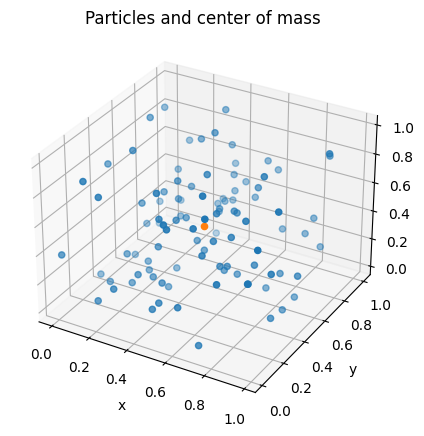

In [10]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection = '3d')

ax.set_title('Particles and center of mass')
ax.scatter(pos[0][:, 0], pos[0][:, 1], pos[0][:, 2])
ax.scatter(CM[0, 0], CM[0, 1], CM[0, 2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In this tutorial we are going to determine the center of mass $\mathbf{r}_{CM}^{i}$ of each box $i$, given each particle position $\mathbf{r}_i$ for each box:
$$\{ \mathbf{r}_{CM}^{i} \} \Rightarrow \{ \mathbf{r}_i \}$$
using a simple **Graph Neural Network** using `Pytorch Geometric`.

## 3) Generating the data set

### 3.1) Graphs

Now our data set does not consist in predicting a simple relation for a tabular data ($\{x\} \Rightarrow \{y\}$). For each set of irregular data (for each box with a bunch of particles randomly distributed) we are going to predict a **global property**, i.e., their **center of mass** (which is a $3 D$ information). The easy way to represent this problem is using **graphs**.

![](https://blog.fastforwardlabs.com/images/editor_uploads/2019-10-25-173715-graph_basics.png)
###### [Image source: [https://blog.fastforwardlabs.com/images/editor_uploads/2019-10-25-173715-graph_basics.png](https://blog.fastforwardlabs.com/images/editor_uploads/2019-10-25-173715-graph_basics.png)]

**Graphs** are mathematical units represented by $3$ numbers: $G = G (n_i, e_{i j}, g)$:
* $n_i$: node attributes (properties related to the objects translated into graphs)
* $e_{i j}$: edge attributes (usually properties related to the two nodes in question)
* $g$: global attribute (which represent the entire graph)

(Almost) everything can be translated into a **graph**!

Let`s built the most simple graph ever: a graph with $3$ nodes: $[0, 1, 2]$, with node attributes $x_1 \in [-1, 0, 1]$ and $4$ edges (lines that take one node to another, as well theirs vice versa):

![](https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg)

In [11]:
edge_index = torch.tensor([[0, 1], [1, 0],
                           [1, 2], [2, 1]], dtype = torch.long) #Edge indexes
x = torch.tensor([[-1], [0], [1]], dtype = torch.float) #Node attributes
g = torch.tensor( [[3]], dtype = torch.int ) #Global attribute (number of nodes)

graph = Data(x = x, edge_index = edge_index.t().contiguous(), u = g)
graph

Data(x=[3, 1], edge_index=[2, 4], u=[1, 1])

We can even visualize the graph using:

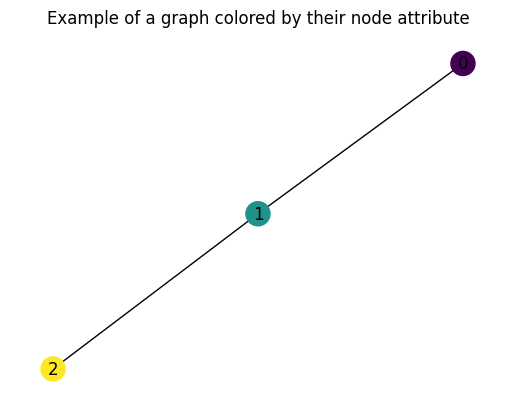

In [12]:
plt.figure(dpi = 100)
plt.title('Example of a graph colored by their node attribute')
G = to_networkx(graph, to_undirected = True)
nx.draw(G, node_color = graph.x[:, -1], node_size = 300, with_labels = True)

In our case one way to convert the particles in each box is considering the _particles_ as our **nodes**, link them using their positions and considering as **edge attribute** the distance between $2$ particles and the node attributes as the particle's position ($x, y, z$). Because we always consider the same number of particles per box, we do not need to consider any **global attribute** (i.e., the only global property is the same for all of the boxes). The hard part is to find the **edge indexes** (because we will not chose each one of them by hand)!

Now it is time to convert the _boxes_ into **graphs**. In this tutorial I will present how get the **edge indexes** using:
* [`KDTree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html): is a way to organize a bunch of points, returning indices to them, corresponding to points inside some certain distance $r$,
* [`kNN`](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/transforms/knn_graph.html): is a way to organize a bunch of points, returning indices to them, based in $k$ nearest neighbors of each point.

In [13]:
def get_edges_KDTree(pos, r_link):
  '''
  Compute KDTree and get edge links (KDTree) and edge features (particles` distance)
  '''
  # 1. Get edges
  kd_tree = SS.KDTree(pos, boxsize = 1.0)
  edge_index = kd_tree.query_pairs(r = r_link, output_type = "ndarray")

  edge_index = edge_index.astype(int)

  # Write in pytorch-geometric format
  edge_index = edge_index.reshape((2, -1))

  # 2. Get edge attributes
  row, col = edge_index
  diff = pos[row] - pos[col]

  # Distance
  dist = np.linalg.norm(diff, axis = 1)

  edge_attr = np.concatenate([dist.reshape(-1, 1)])

  return edge_index, edge_attr

In [14]:
def get_edges_kNN(pos, k_number):
  '''
  Compute knn graph and get edges and edge features
  '''
  # 1. Get edges
  edge_index = knn_graph(torch.tensor(pos, dtype = torch.float32), k = k_number, loop = False)

  # 2. Get edge attributes
  row, col = edge_index
  diff = pos[row] - pos[col]

  # Distance
  dist = np.linalg.norm(diff, axis = 1)

  edge_attr = np.concatenate([dist.reshape(-1, 1)])

  return edge_index, edge_attr

Let's create the function to create our graphs for both methods:

In [15]:
def create_graphs_KDTree(pos, NB):

    #Getting the edge indexes and edge attributes
    edges = {}
    edges_atrs = {}
    for i in range(NB):
        edges[i], edges_atrs[i] = get_edges_KDTree(pos[i], 0.3)

    #Getting the node attributes
    x = {}
    for i in range(NB):
        x[i] = np.zeros( ( pos[i].shape[0], 3 ) )
    for i in range(NB):
      x[i][:, 0] = pos[i][:, 0]
      x[i][:, 1] = pos[i][:, 1]
      x[i][:, 2] = pos[i][:, 2]

    #Getting the target attributes
    y = np.zeros( (NB, 3) )
    for i in range(NB):
      y[i, :] = (CM[i, :] - mean)/std #Data pre-processing the target value

    dataset = []
    for i in range(NB):
        edge_index = torch.tensor(edges[i].T, dtype = torch.long)
        edge_atrs = torch.tensor(edges_atrs[i], dtype = torch.float)
        xs = torch.tensor(x[i], dtype = torch.float32)
        ys = np.reshape(y[i], (1, 3))
        data = Data(x = xs, edge_index = edge_index.t().contiguous(), edge_atrs = edge_atrs, y = ys)
        dataset.append(data)

    return dataset

In [16]:
def create_graphs_kNN(pos, NB):

    #Getting the edge indexes and edge attributes
    edges = {}
    edges_atrs = {}
    for i in range(NB):
        edges[i], edges_atrs[i] = get_edges_kNN(pos[i], 10)

    #Getting the node attributes
    x = {}
    for i in range(NB):
        x[i] = np.zeros( ( pos[i].shape[0], 3 ) )
    for i in range(NB):
      x[i][:, 0] = pos[i][:, 0]
      x[i][:, 1] = pos[i][:, 1]
      x[i][:, 2] = pos[i][:, 2]

    #Getting the target attributes
    y = np.zeros( (NB, 3) )
    for i in range(NB):
      y[i, :] = (CM[i, :] - mean)/std #Data pre-processing the target value

    dataset = []
    for i in range(NB):
        edge_index = torch.tensor(edges[i].T, dtype = torch.long)
        edge_atrs = torch.tensor(edges_atrs[i], dtype = torch.float)
        xs = torch.tensor(x[i], dtype = torch.float32)
        ys = np.reshape(y[i], (1, 3))
        data = Data(x = xs, edge_index = edge_index.t().contiguous(), edge_atrs = edge_atrs, y = ys)
        dataset.append(data)

    return dataset

Creating the data sets:

In [17]:
dataset_KDTree = create_graphs_KDTree(pos, NB)

In [18]:
dataset_KDTree[0]

Data(x=[100, 3], edge_index=[2, 575], y=[1, 3], edge_atrs=[575, 1])

In [19]:
dataset_kNN = create_graphs_kNN(pos, NB)

In [20]:
dataset_kNN[0]

Data(x=[100, 3], edge_index=[2, 1000], y=[1, 3], edge_atrs=[1000, 1])

Visualizing the data sets:

In [21]:
# Visualizing the raphs
def visualize_graph(data, projection = "3d", title = 'Graph', edge_index = None):

    fig = plt.figure(dpi = 100, figsize = (5, 5))

    ax = fig.add_subplot(projection = "3d")
    pos = data.x[:, :3]

    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Draw lines for each edge
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():

            src = pos[src].tolist()
            dst = pos[dst].tolist()

            ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth = 0.1, color='black')

    # Plot nodes
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s = 30, zorder = 1000)

    plt.show()

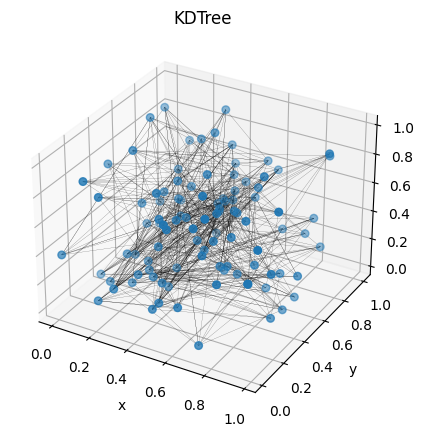

In [22]:
visualize_graph(dataset_KDTree[0], title = "KDTree", edge_index = dataset_KDTree[0].edge_index)

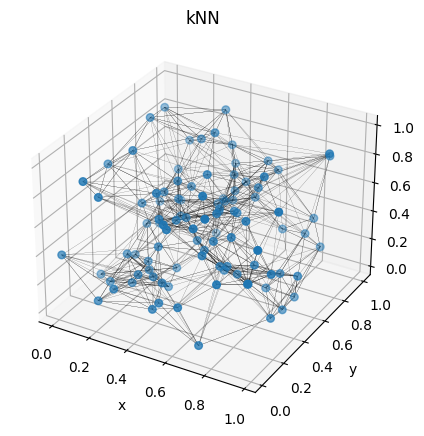

In [23]:
visualize_graph(dataset_kNN[0], title = "kNN", edge_index = dataset_kNN[0].edge_index)

Let's stick with the kNN method (because we do not need periodic boundary conditions):

In [24]:
dataset = dataset_kNN

## 4) Transforming the dataset

In [25]:
def transform_dataset(dataset, frac_train, frac_val, batch_size):
    '''
    frac_train: fraction of the dataset to use in the training
    frac_val:   fraction of the dataset to use in the validation
    batch_size: number of samples to work through before updating the internal model parameters
    '''

    #Getting the training, validation, and testing sets

    dataset_train = dataset[:int(len(dataset)*frac_train)]
    dataset_val = dataset[int(len(dataset)*frac_train):int(len(dataset)*(frac_train + frac_val))]
    dataset_test = dataset[int(len(dataset)*(frac_train + frac_val)):]

    #Organizing in batches
    train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size)
    val_loader = DataLoader(dataset = dataset_val, batch_size = batch_size)
    test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size)

    return train_loader, val_loader, test_loader

In [26]:
train_loader, val_loader, test_loader = transform_dataset(dataset, 0.8, 0.1, 40)

## 5) Defining the model

Here we are going to implement the **Message Passing Scheme** architecture, which means we are going to conserve the graph shape and **update** their **node** and **edge** values using a model designed to do so! Let's describe the **edge** and **node** models:

* **Edge model**
  \begin{equation}
   \mathbf{e}_{i j}^{(\ell + 1)} = \mathcal{E}^{(\ell + 1)} \left( \left[ \mathbf{n}_{i}^{(\ell)}, 
   \mathbf{n}_{j}^{(\ell)}, \mathbf{e}_{i j}^{(\ell)} \right]  \right) ,
  \end{equation}
  where $\mathcal{E}^{(\ell + 1)}$ represents a MLP;
* **Node model**
  \begin{equation}
   \mathbf{n}_{i}^{(\ell + 1)} = \mathcal{N}^{(\ell + 1)} \left( \left[ \mathbf{n}_{i}^{(\ell)}, 
   \bigoplus_{j \in \mathfrak{N}_i} \mathbf{e}_{i j}^{(\ell + 1)} \right]  \right) ,
  \end{equation}
  where $\mathfrak{N}_i$ represents all neighbors of node $i$, $\mathcal{N}^{(\ell + 1)}$ is 
  a NN, and $\oplus$ is a multi-pooling operation responsible to concatenate several 
  permutation invariant operations:
  \begin{equation}
   \bigoplus_{j \in \mathfrak{N}_i} \mathbf{e}_{i j}^{(\ell + 1)} = \left[ 
   \max_{j \in \mathfrak{N}_i} \mathbf{e}_{i j}^{(\ell + 1)},
   \sum_{j \in \mathfrak{N}_i} \mathbf{e}_{i j}^{(\ell + 1)},
   \frac{ \sum_{j \in \mathfrak{N}_i} \mathbf{e}_{i j}^{(\ell + 1)} }{ \sum_{j \in \mathfrak{N}_i} }
   \right] .  
  \end{equation}
Several aggregators can enhance the expressiveness of GNN!

In the case of the code we are going to implement these updates using `MetaLayer`s!

Once the graph has been updated using the $N$ message passing layers, we collapse it into a 1-dimensional feature vector using 
\begin{equation}
  \mathbf{y} = \mathcal{F} \left( \left[ \bigoplus_{i \in \mathfrak{F}} \mathbf{n}_i^N \right] \right) ,
\end{equation}
where $\mathcal{F}$ is the last MLP, $\oplus_{i \in \mathfrak{F}}$ the last multi-pooling
operation (operating over all nodes in the graph $\mathfrak{F}$), and $\mathbf{y}$ represents the target of the GNN.

Now it is time to code!

In [27]:
'''
Defining the GNN parameters to run the code
'''

num_node_in = 3 #We are working with 3 node attributes
num_node_out = 3 #We will compute the 3D center of mass

hiddens = 32 #Fixing the number of neurons per layer, just for simplicity

num_edge_in = 1 #Our number of edge attributes is only one (distance between nodes)
num_edge_out = 1 #Same

In [28]:
class EdgeModel(torch.nn.Module):
  
    def __init__(self, num_node_in, num_node_out, num_edge_in, num_edge_out, 
                 hiddens):
        
        super().__init__()
        
        in_channels = ( 2 * num_node_in + num_edge_in) #Considering both nodes and the edge in question

        #MLP layer archtecture
        layers = [Linear(in_channels, hiddens),
                  LeakyReLU(0.2),
                  Linear(hiddens, num_edge_out)]

        #Defining the MLP
        self.edge_mlp = Sequential(*layers)
                                   
    def forward(self, src, dest, edge_atrs, u, batch):
      # src: source nodes
      # dst: destination nodes
      # edge_atrs: edge attributes
      # u: global properties  

      #Updating the edges considering the nodes and edges
      out = torch.cat([src, dest, edge_atrs], dim = 1)

      #Applying the MLP
      out = self.edge_mlp(out)
      
      return out

In [29]:
class NodeModel(torch.nn.Module):

    def __init__(self, num_node_in, num_node_out, num_edge_in, num_edge_out,
                 hiddens):

        super().__init__()

        in_channels = num_node_in + 3*num_edge_out #Considering the node in question and 3 pooling operations

        #MLP layer archtecture
        layers = [Linear(in_channels, hiddens),
                  LeakyReLU(0.2),
                  Linear(hiddens, num_node_out)]

        #Defining the MLP
        self.node_mlp = Sequential(*layers)

    def forward(self, x, edge_index, edge_atrs, u, batch):
        # x: node attributes
        # edge_index: edge indexes
        # edge_atrs: edge attributes
        # u: global property

        row, col = edge_index

        #The edge attributes
        out = edge_atrs

        #Multipooling the edge attributes
        out1 = scatter_add(out, col, dim = 0, dim_size = x.size(0))
        out2 = scatter_max(out, col, dim = 0, dim_size = x.size(0))[0]
        out3 = scatter_mean(out, col, dim = 0, dim_size = x.size(0))

        #Updating the node considering the node and the multipooling operation in the edges
        out = torch.cat([x, out1, out2, out3], dim = 1)

        #Applying the MLP
        out = self.node_mlp(out)

        return out

In [30]:
class GNN(torch.nn.Module):

  def __init__(self, node_features, n_layers, hidden_channels, global_out):

    super().__init__()

    self.n_layers = n_layers #Defining the number of Metalayers
    self.global_out = global_out #Defining the dimension of the final output

    num_node_in = node_features #Defining the number of input node features
    num_node_out = num_node_in #Defining the number of output node features

    num_edge_in = 1 #Defining the number of input edge features
    num_edge_out = num_edge_in #Defining the number of output edge features

    layers = []

    #Defining the first MetaLayer: with the node and edge models
    inlayer = MetaLayer(edge_model = EdgeModel(num_node_in, num_node_out,
                                               num_edge_in, num_edge_out,
                                               hidden_channels),
                         node_model = NodeModel(num_node_in, num_node_out,
                                                num_edge_in, num_edge_out,
                                                hidden_channels)
                         )

    layers.append(inlayer)

    num_node_in = num_node_out
    num_edge_in = num_edge_out

    #Defining the inner MetaLayers: with the node and edge models - the hidden graph blocks
    for i in range(self.n_layers - 1):

      layer_hidden = MetaLayer(edge_model = EdgeModel(num_node_in, num_node_out,
                                                      num_edge_in, num_edge_out,
                                                      hidden_channels),
                              node_model = NodeModel(num_node_in, num_node_out,
                                                     num_edge_in, num_edge_out,
                                                     hidden_channels)
                              )
      layers.append(layer_hidden)

    self.layers = ModuleList(layers)

    #Defining the MLP for the compressed version of the graph
    self.final_out_layer = Sequential(
                                      Linear(3*num_node_out, hidden_channels),
                                      LeakyReLU(0.2),
                                      Linear(hidden_channels, hidden_channels),
                                      LeakyReLU(0.2),
                                      Linear(hidden_channels, hidden_channels),
                                      LeakyReLU(0.2),
                                      Linear(hidden_channels, self.global_out)
                                      )

  def forward(self, data):

    x, edge_index, edge_atrs, batch = data.x, data.edge_index, data.edge_atrs, data.batch

    #Message passing
    for layer in self.layers:
      x, edge_atrs, _ = layer(x, edge_index, edge_atrs, None, data.batch)

    #Multipooling all the nodes
    addpool = global_add_pool(x, batch)
    maxpool = global_max_pool(x, batch)
    meanpool = global_mean_pool(x, batch)

    #Concatenating the compressed version of the graph
    out = torch.cat( [ addpool, maxpool, meanpool], dim = 1 )

    #Final linear layer
    out = self.final_out_layer(out)

    return out

Instantiating the model

In [31]:
model = GNN(node_features = num_node_in, n_layers = 2,
            hidden_channels = hiddens, global_out = 3).to(device)
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=7, out_features=32, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    ),
      node_model=NodeModel(
      (node_mlp): Sequential(
        (0): Linear(in_features=6, out_features=32, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=32, out_features=3, bias=True)
      )
    ),
      global_model=None
    )
  )
  (final_out_layer): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

## 6) Defining the `optimizer` and `loss function`

* **optimizer:** algorithm that adjust the model parameters during training to minimize the loss function
    * `learning rate`: a hyper-parameter used to govern the pace at which an algorithm updates or learns the values of a parameter estimate
    * `weight decay`: is an additional term in the weight update rule that causes the weights to exponentially decay to zero
* **loss function:** a mathematical function that quantifies the difference between predicted and actual values

In [32]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-6)

## 7) Training and validating the model

In [33]:
epochs = 200

lloss_train = []
lloss_val = []

print("Starting training...")

for i in range(epochs):

    model.train()  #Telling the model we are training :p
    aux_train = 0
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, torch.from_numpy( np.array(data.y)[:, 0] ).float().to(device) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        aux_train += loss.item()
    lloss_train.append( aux_train/len(train_loader) )

    if i % 20 == 0:
        print(f"Epoch {i} | Train Loss {aux_train/len(train_loader)}")

    model.eval() #Telling the model we are testing :p
    aux_val = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, torch.from_numpy( np.array(data.y)[:, 0] ).float().to(device) )
        aux_val += loss.item()
    lloss_val.append( aux_val/len(val_loader) )

    if i % 20 == 0:
        print(f"Epoch {i} | Train Loss {aux_val/len(val_loader)}")

Starting training...
Epoch 0 | Train Loss 1.0298169806599617
Epoch 0 | Train Loss 0.9421060919761658
Epoch 20 | Train Loss 0.6683023065328598
Epoch 20 | Train Loss 0.6889591932296752
Epoch 40 | Train Loss 0.6698904938995838
Epoch 40 | Train Loss 0.706679904460907
Epoch 60 | Train Loss 0.3434819791465998
Epoch 60 | Train Loss 0.3488182067871094
Epoch 80 | Train Loss 0.33325939401984217
Epoch 80 | Train Loss 0.35060476064682006
Epoch 100 | Train Loss 0.33165969923138616
Epoch 100 | Train Loss 0.35136141180992125
Epoch 120 | Train Loss 0.32931194081902504
Epoch 120 | Train Loss 0.35283259153366087
Epoch 140 | Train Loss 0.33768051825463774
Epoch 140 | Train Loss 0.36824336647987366
Epoch 160 | Train Loss 0.32825131341814995
Epoch 160 | Train Loss 0.35845779776573183
Epoch 180 | Train Loss 0.32863069884479046
Epoch 180 | Train Loss 0.3527149736881256


## 8) Taking a look at the loss function

Here we can see if our model is **overfitting**, **underfitting** or doing well

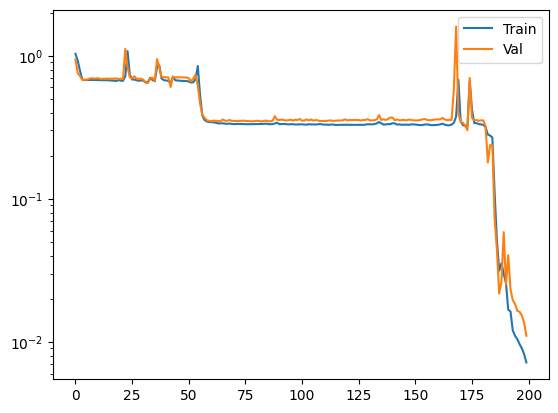

In [34]:
plt.figure(dpi = 100)
plt.plot(lloss_train, label = 'Train')
plt.plot(lloss_val, label = 'Val')
plt.legend()
plt.yscale('log')

## 9) Testing the model in the test set

In [35]:
lloss_test = []
preds = []
yss = []
for data in test_loader:
  out = model(data.to(device))
  preds.append( out.detach().cpu().numpy() )
  yss.append( np.array(data.y) )
  loss = loss_fn(out, torch.from_numpy( np.array(data.y)[:, 0] ).float().to(device) )
lloss_test.append( loss.data.cpu().numpy() )
loss_test = np.mean(lloss_test)
loss_test

0.010641804

In [36]:
new_preds = np.concatenate( [preds[i] for i in range(len(preds))])
new_yss = np.concatenate( [yss[i][:, 0, :] for i in range(len(yss))])
new_preds.shape, new_yss.shape

((200, 3), (200, 3))

### 9.1) Computing the MSE for the test set

In [37]:
MSE_test = mean_squared_error(new_preds*std + mean, new_yss*std + mean)
MSE_test

9.488524694236452e-06

### 9.2) Arranging the data in a DataFrame and recovering the units

In [38]:
df = pd.DataFrame()

df["y_real_x"] = new_yss[:, 0]*std[0] + mean[0]
df["y_pred_x"] = new_preds[:, 0]*std[0] + mean[0]

df["y_real_y"] = new_yss[:, 1]*std[1] + mean[1]
df["y_pred_y"] = new_preds[:, 1]*std[1] + mean[1]

df["y_real_z"] = new_yss[:, 2]*std[2] + mean[2]
df["y_pred_z"] = new_preds[:, 2]*std[2] + mean[2]

### 9.3) Looking at the predictions for the test set

Text(0.5, 0, 'Center of mass')

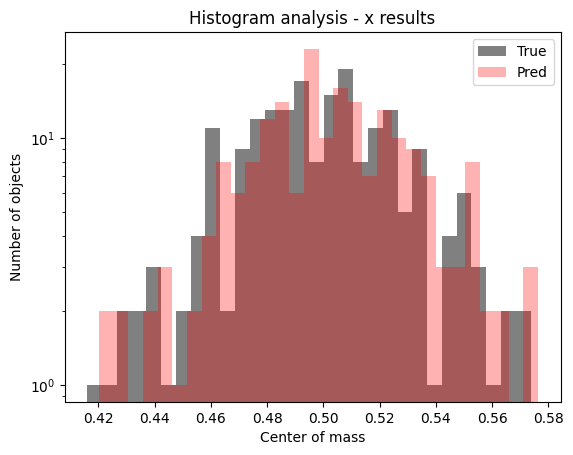

In [39]:
plt.figure(dpi = 100)
plt.hist(df["y_real_x"], bins = 30, label = 'True', color = "gray")
plt.hist(df["y_pred_x"], bins = 30, alpha = 0.3, label = 'Pred', color = "red")
plt.yscale('log')
plt.legend()
plt.title('Histogram analysis - x results')
plt.ylabel('Number of objects')
plt.xlabel('Center of mass')

Text(0.5, 0, 'Center of mass')

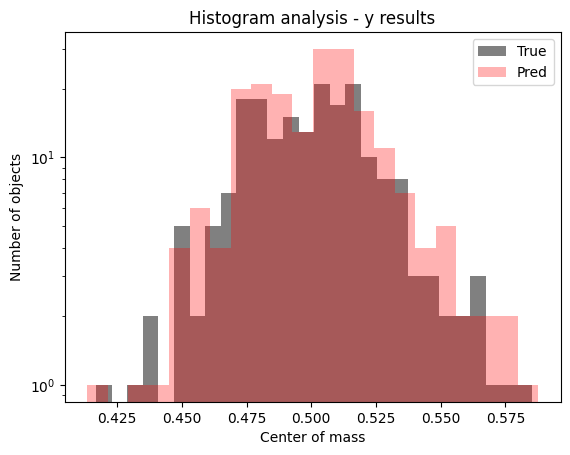

In [40]:
plt.figure(dpi = 100)
plt.hist(df["y_real_y"], bins = 28, label = 'True', color = "gray")
plt.hist(df["y_pred_y"], bins = 22, alpha = 0.3, label = 'Pred', color = "red")
plt.yscale('log')
plt.legend()
plt.title('Histogram analysis - y results')
plt.ylabel('Number of objects')
plt.xlabel('Center of mass')

Text(0.5, 0, 'Center of mass')

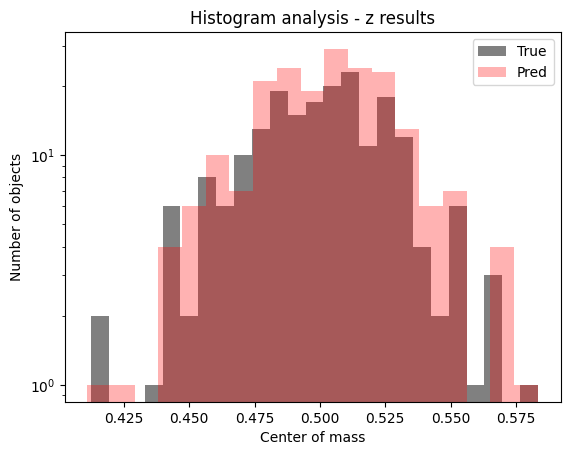

In [41]:
plt.figure(dpi = 100)
plt.hist(df["y_real_z"], bins = 25, label = 'True', color = "gray")
plt.hist(df["y_pred_z"], bins = 19, alpha = 0.3, label = 'Pred', color = "red")
plt.yscale('log')
plt.legend()
plt.title('Histogram analysis - z results')
plt.ylabel('Number of objects')
plt.xlabel('Center of mass')

Text(0.5, 0, 'CM')

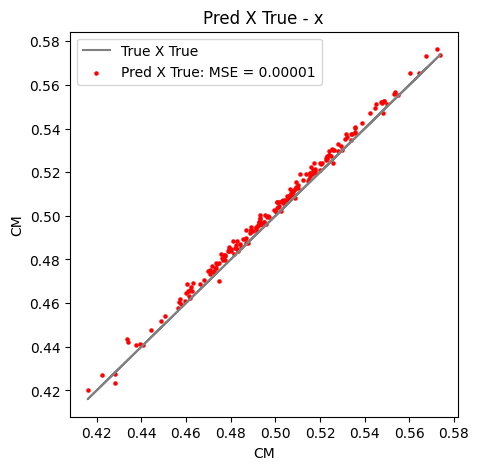

In [42]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X True - x')
plt.plot(df['y_real_x'], df['y_real_x'], label = 'True X True', color = 'gray')
plt.scatter(df['y_real_x'], df['y_pred_x'], s = 5, label = 'Pred X True: MSE = {:.5f}'.format(MSE_test), color = 'red')
plt.legend()
plt.ylabel('CM')
plt.xlabel('CM')

Text(0.5, 0, 'CM')

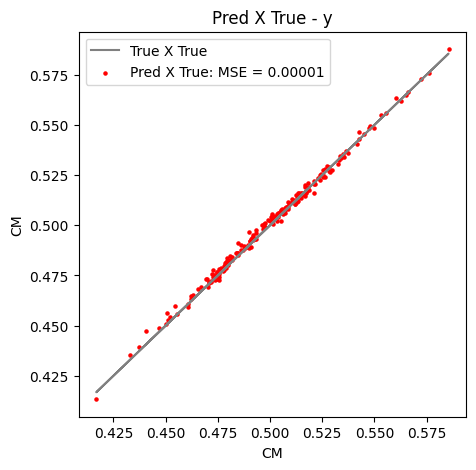

In [43]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X True - y')
plt.plot(df['y_real_y'], df['y_real_y'], color = 'gray', label = 'True X True')
plt.scatter(df['y_real_y'], df['y_pred_y'], s = 5, label = 'Pred X True: MSE = {:.5f}'.format(MSE_test), color = 'red')
plt.legend()
plt.ylabel('CM')
plt.xlabel('CM')

Text(0.5, 0, 'CM')

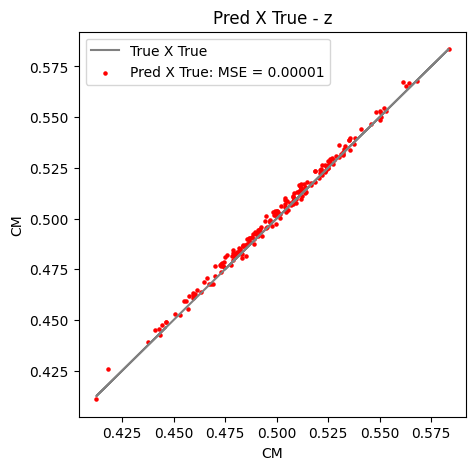

In [44]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X True - z')
plt.plot(df['y_real_z'], df['y_real_z'], color = 'gray', label = 'True X True')
plt.scatter(df['y_real_z'], df['y_pred_z'], s = 5, color = 'red', label = 'Pred X True: MSE = {:.5f}'.format(MSE_test))
plt.legend()
plt.ylabel('CM')
plt.xlabel('CM')

## 10) TO DO:

**EXERCISE I:** Change some of the hyperparameters to obtain better predictions

**EXERCISE II:** Rewrite the `box_generator` function considering particles of different masses. Adjust the model hyperparameters to obtain good predictions

**EXERCISE III:** Rewrite the `notebook` to compute the moduli of the center of mass. Remember to adjust the model hyperparameters to obtain good predictions

**EXERCISE IV:** Rewrite the `notebook` to compute the moduli of the center of mass, considering a different number of particles per. Remember to adjust the model hyperparameters to obtain good predictions